# Twitter Gender Classification
### Final Project

#### University of California, Santa Barbara
#### PSTAT 135: Big Data Analytics

Source: https://www.kaggle.com/crowdflower/twitter-user-gender-classification

# Dataset Preprocessing

The dataset contains about 20,000 rows, each with a user name, a random tweet, profile image and statistics, location, and link and sidebar color. All tweets were posted in 2015.

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession \
        .builder \
        .appName("comm") \
        .getOrCreate()

tweets = spark.read.csv('gender_data.csv', header = True)

In [2]:
type(tweets)

pyspark.sql.dataframe.DataFrame

In [3]:
tweets.count()

24230

In [4]:
tweets.columns

['_unit_id',
 '_golden',
 '_unit_state',
 '_trusted_judgments',
 '_last_judgment_at',
 'gender',
 'gender:confidence',
 'profile_yn',
 'profile_yn:confidence',
 'created',
 'description',
 'fav_number',
 'gender_gold',
 'link_color',
 'name',
 'profile_yn_gold',
 'profileimage',
 'retweet_count',
 'sidebar_color',
 'text',
 'tweet_coord',
 'tweet_count',
 'tweet_created',
 'tweet_id',
 'tweet_location',
 'user_timezone']

We remove columns `_unit_id`, `_golden`, `_unit_state`, `_last_judgment_at`,`_trusted_judgments`, `gender:confidence`, `profile_yn`, `profile_yn:confidence`, `description`, `gender_gold`, `link_color`,`name`, `profile_yn_gold`, `profileimage`, `sidebar_color`, `tweet_coord`, `tweet_id`, `tweet_location`, and `user_timezone` because they were not relevant in our model/purpose....

In [5]:
tweets = tweets.select(['gender','created','fav_number','retweet_count','text','tweet_count','tweet_created'])
tweets.show(5)

+------+--------------+----------+-------------+--------------------+-----------+--------------+
|gender|       created|fav_number|retweet_count|                text|tweet_count| tweet_created|
+------+--------------+----------+-------------+--------------------+-----------+--------------+
|  male|  12/5/13 1:48|         0|            0|Robbie E Responds...|     110964|10/26/15 12:40|
|  male| 10/1/12 13:51|        68|            0|���It felt like t...|       7471|10/26/15 12:40|
|  male|11/28/14 11:30|      7696|            1|i absolutely ador...|       5617|10/26/15 12:40|
|  male| 6/11/09 22:39|       202|            0|Hi @JordanSpieth ...|       1693|10/26/15 12:40|
|female| 4/16/14 13:23|     37318|            0|Watching Neighbou...|      31462|10/26/15 12:40|
+------+--------------+----------+-------------+--------------------+-----------+--------------+
only showing top 5 rows



In [6]:
tweets.groupBy('gender').count().sort('count', ascending = False).show()

+--------------------+-----+
|              gender|count|
+--------------------+-----+
|              female| 6700|
|                male| 6194|
|               brand| 5942|
|                null| 3188|
|             unknown| 1117|
|          6.5874E+17|   83|
|          6.5873E+17|   62|
|              Medina|   14|
|              London|   13|
|      10/26/15 12:40|   11|
|Porto, Portugal �...|   10|
|1/16 cute pickle ...|   10|
|              0084B4|    9|
|Republic of the P...|    8|
|                  UK|    7|
|                 USA|    7|
|         3/4 + band |    6|
|              FF005E|    6|
|PRE-ORDER MADE IN...|    5|
|           New York |    4|
+--------------------+-----+
only showing top 20 rows



As we can see above, the `gender` column contains many labels. We decide to keep only the tweets made by a `male`, `female`, or `brand` since they are the most common.

In [7]:
tweets = tweets.filter((tweets.gender == 'male') | (tweets.gender == 'female') | (tweets.gender == 'brand'))
tweets.count()

18836

### Checking for Null Values

We will remove any null values in `text` since we are only interested in predicting gender for users with tweets.

In [8]:
# Number of null values in "text"
tweets.filter(tweets.text.isNull()).count()

1088

In [9]:
tweets = tweets.filter(tweets.text.isNotNull())
tweets.count()

17748

For columns `fav_number`, `retweet_count`, and `tweet_count`:

- If more than 10% of the values are null, we will not include that column later on in our model. 

- If less than 10% of the values are null, we will replace null values with the median of that specific column. We chose median because there is a possibility the mean could be something like 77.5, and you cannot retweet something 77.5 times.

- If there are no null values, we will keep the column unchanged.

In [10]:
# Percentage of null values in "fav_number"
tweets.filter(tweets.fav_number.isNull()).count()/tweets.count()

0.0

In [11]:
# Percentage of null values in "retweet_count"
tweets.filter(tweets.retweet_count.isNull()).count()/tweets.count()

0.0

In [12]:
# Percentage of null values in "tweet_count"
tweets.filter(tweets.tweet_count.isNull()).count()/tweets.count()

0.07093757043047104

Since less than 10% of `tweet_count` values are null, we will replace them with the median value of `tweet_count` during pipeline building.

# Exploratory Data Analysis

In [13]:
tweets.groupBy('gender').count().orderBy('count',ascending=False).show()

+------+-----+
|gender|count|
+------+-----+
|female| 6354|
|  male| 5776|
| brand| 5618|
+------+-----+



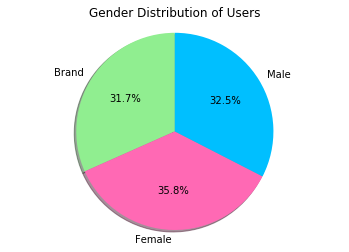

In [14]:
# Pie chart of genders
import matplotlib.pyplot as plt
labels = 'Brand', 'Female', 'Male'
sizes = [5618, 6354, 5776]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['lightgreen', 'hotpink', 'deepskyblue'])
ax1.axis('equal')
plt.title('Gender Distribution of Users')
plt.show()

In [15]:
tweets.groupBy('gender') \
    .agg({'fav_number':'avg','retweet_count':'avg','tweet_count':'avg'}).show()

+------+-----------------+-----------------+-------------------+
|gender| avg(tweet_count)|  avg(fav_number)| avg(retweet_count)|
+------+-----------------+-----------------+-------------------+
|female|26868.96356206368|6039.206956248033|0.04737173434057287|
| brand| 63219.3443287037|2086.142043431826|0.11765752936988252|
|  male|30534.52625698324|4929.307825484764|0.09279778393351801|
+------+-----------------+-----------------+-------------------+



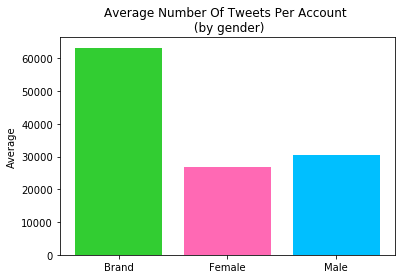

In [16]:
# Bar Plot of average number of tweets per account by gender
tweet_count_x = ['Brand', 'Female', 'Male']
tweet_count_avg = [63219.344329, 26868.963562, 30534.526257]
x_pos = [i for i, _ in enumerate(tweet_count_x)]
plt.bar(tweet_count_x, tweet_count_avg, color=['limegreen','hotpink','deepskyblue'])
plt.ylabel("Average")
plt.title("Average Number Of Tweets Per Account \n (by gender)")
plt.xticks(x_pos, tweet_count_x)
plt.show()

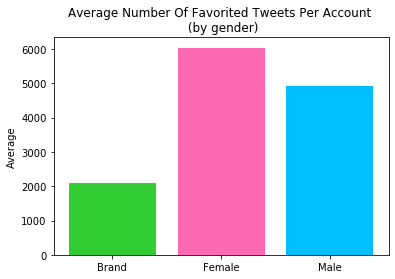

In [17]:
# Bar Plot of average number of favorites per account by gender
fav_number_x = ['Brand', 'Female', 'Male']
fav_number_avg = [2086.142043431826, 6039.206956248033, 4929.307825484764]
x_pos = [i for i, _ in enumerate(fav_number_x)]
plt.bar(fav_number_x, fav_number_avg, color=['limegreen','hotpink','deepskyblue'])
plt.ylabel("Average")
plt.title("Average Number Of Favorited Tweets Per Account \n (by gender)")
plt.xticks(x_pos, fav_number_x)
plt.show()

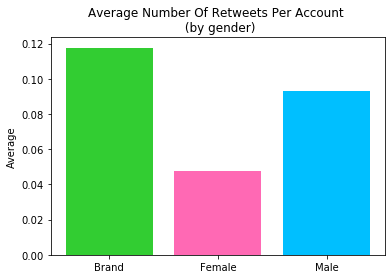

In [18]:
# Bar Plot of average number of retweets per account by gender
retweet_count_x = ['Brand', 'Female', 'Male']
retweet_count_avg = [0.11765752936988252, 0.04737173434057287, 0.09279778393351801]
x_pos = [i for i, _ in enumerate(retweet_count_x)]
plt.bar(retweet_count_x, retweet_count_avg, color=['limegreen','hotpink','deepskyblue'])
plt.ylabel("Average")
plt.title("Average Number Of Retweets Per Account \n (by gender)")
plt.xticks(x_pos, retweet_count_x)
plt.show()

### Converting Columns to Type Integer

In [19]:
tweets = tweets.withColumn("fav_number",tweets["fav_number"].cast('integer'))
tweets = tweets.withColumn("retweet_count",tweets["retweet_count"].cast('integer'))
tweets = tweets.withColumn("tweet_count",tweets["tweet_count"].cast('integer'))

### Creating New Columns for Punctuation Counts, Emoji Existence, and Account Years

Getting punctuation counts for each tweet.

In [20]:
from string import punctuation
from collections import Counter
def punc_func(tweet):
    sum = 0
    for key in tweet:
        if key in punctuation:
            sum += tweet[key]
    return sum

In [21]:
punc = tweets.select("text").rdd.map(lambda tweet: Counter(str(tweet))) \
            .map(lambda x: punc_func(x)).map(lambda x: (x, )).toDF(['punc'])
punc.show(5)

+----+
|punc|
+----+
|  11|
|  18|
|   5|
|  19|
|  15|
+----+
only showing top 5 rows



Getting boolean values if an emoji, represented by the character '�', is present in a tweet (True) or not present in a tweet (False).

In [22]:
emojis = tweets.select("text").rdd.map(lambda tweet: str(tweet)) \
            .map(lambda x: '�' in x).map(lambda x: (x, )).toDF(['emojis'])
emojis.show(5)

+------+
|emojis|
+------+
| false|
|  true|
| false|
| false|
|  true|
+------+
only showing top 5 rows



Getting the number of years each Twitter user has had their account.

In [23]:
# extracting only the "year" part of 'created' & subtracting it from 15 (representing 2015)
years = tweets.rdd.map(lambda row: row['created'].split(' ')) \
                .map(lambda x: x[0]) \
                .map(lambda x: x.split('/')) \
                .map(lambda x: x[2]) \
                .map(lambda x: (15-int(x))) \
                .map(lambda x: (x, )).toDF(['account_years'])
years.show(5)

+-------------+
|account_years|
+-------------+
|            2|
|            3|
|            1|
|            6|
|            1|
+-------------+
only showing top 5 rows



### Lowercasing Tweets

The last step before we configure our first pipeline is to lowercase the tweets in `text` column.

In [24]:
from pyspark.sql.functions import lower, col
tweets = tweets.withColumn("text",lower(col('text')))
tweets.select("text").show(1, truncate=False)

+-------------------------------------------------------------------------------------------------------------+
|text                                                                                                         |
+-------------------------------------------------------------------------------------------------------------+
|robbie e responds to critics after win against eddie edwards in the #worldtitleseries https://t.co/nsybbmvjkz|
+-------------------------------------------------------------------------------------------------------------+
only showing top 1 row



# Pipeline Building

In [25]:
from pyspark.ml import Pipeline  
from pyspark.ml.feature import * 

### Pipeline 1
For our first pipeline we:
- impute median values in `tweet_count`
- convert `gender` to numeric type
- tokenize and remove stop words in `text`

In [26]:
# impute median to null values in "tweet_count"
imputer = Imputer(inputCols=["tweet_count"], outputCols=["tweet_count_new"]).setStrategy("median")

# convert "gender" to numeric type (0 = female, 1 = male, 2 = brand)
indexer = StringIndexer(inputCol="gender", outputCol="gender_num")

# process "text"
tokenizer = Tokenizer(inputCol="text", outputCol="words") #tokenize
remover = StopWordsRemover(inputCol="words", outputCol="filtered") #remove stop words

# build pipeline
pipeline = Pipeline(stages=[imputer, indexer, tokenizer, remover])

# fit & tranform pipeline
tweets = pipeline.fit(tweets).transform(tweets)

Since ML Feature library does not support stemming, we decide to stem the `text` column using the `SnowballStemmer` package.

In [27]:
from pyspark.sql.functions import udf
from nltk.stem.snowball import SnowballStemmer
from pyspark.sql.types import ArrayType, StringType

stemmer = SnowballStemmer(language='english')
stemmer_udf = udf(lambda tokens: [stemmer.stem(token) for token in tokens], ArrayType(StringType()))
stemmed = tweets.withColumn("stemmed", stemmer_udf("filtered")).select("stemmed")
stemmed.show(1, truncate=False)

+----------------------------------------------------------------------------------------+
|stemmed                                                                                 |
+----------------------------------------------------------------------------------------+
|[robbi, e, respond, critic, win, eddi, edward, #worldtitleseri, https://t.co/nsybbmvjkz]|
+----------------------------------------------------------------------------------------+
only showing top 1 row



### Adding Columns to `tweets`
We add `stemmed`,`punc`,`emojis`, and `account_years` to our updated dataset `tweets` from pipeline 1.

In [37]:
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

In [38]:
tweets_new = tweets.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
punc_new = punc.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
emojis_new = emojis.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
years_new=years.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
stemmed_new = stemmed.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

In [39]:
tweets = tweets_new.join(punc_new, on=["row_index"]).join(emojis_new, on=["row_index"]) \
            .join(years_new, on=["row_index"]).join(stemmed_new, on=["row_index"])

In [40]:
tweets.columns

['row_index',
 'gender',
 'created',
 'fav_number',
 'retweet_count',
 'text',
 'tweet_count',
 'tweet_created',
 'tweet_count_new',
 'gender_num',
 'words',
 'filtered',
 'punc',
 'emojis',
 'account_years',
 'stemmed']

### Top 20 Words Used by Gender

In [41]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from random import Random

In [42]:
# Function to create string with all words
def iteration(l):
    string = ''
    for i in range(len(l)):
        string = string + l[i] + ' '
    return string

In [43]:
# Separate data into dataframes by gender
brand_df = tweets.filter((tweets.gender == 'brand'))
female_df = tweets.filter((tweets.gender == 'female'))
male_df = tweets.filter((tweets.gender == 'male'))

In [44]:
# Top 20 words for brand
brand_words = brand_df.select('stemmed').rdd.flatMap(lambda x: x).flatMap(lambda x: x)
brand_wordcounts = brand_words.map(lambda x: (x, 1)) \
                  .reduceByKey(lambda x,y:x+y) \
                  .map(lambda x:(x[1],x[0])) \
                  .sortByKey(False)
brand_wordcounts.take(20)

[(2275, 'weather'),
 (1347, 'get'),
 (1160, 'updat'),
 (1134, 'channel.'),
 (450, '-'),
 (439, ''),
 (215, 'new'),
 (163, 'like'),
 (135, '&amp;'),
 (130, 'love'),
 (127, 'see'),
 (125, 'one'),
 (125, 'us'),
 (112, 'come'),
 (111, 'thank'),
 (111, 'look'),
 (111, 'make'),
 (103, 'go'),
 (99, 'year'),
 (97, 'via')]

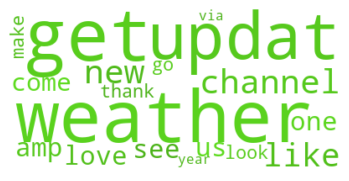

In [45]:
# Brand Word Cloud
stop_words = []

brand_text = iteration(brand_wordcounts.map(lambda x: x[1]).take(20))
brand_wordcloud = WordCloud(stopwords = stop_words, background_color="white").generate(brand_text)

def green_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(100, 75%%, %d%%)" % np.random.randint(40,50))

# Display the generated image:
plt.imshow(brand_wordcloud.recolor(color_func = green_color_func), interpolation='bilinear')
plt.axis("off")
plt.show()

In [47]:
# Top 20 words for female
female_words = female_df.select('stemmed').rdd.flatMap(lambda x: x).flatMap(lambda x: x)
female_wordcounts = female_words.map(lambda x: (x, 1)) \
                  .reduceByKey(lambda x,y:x+y) \
                  .map(lambda x:(x[1],x[0])) \
                  .sortByKey(False)
female_wordcounts.take(20)

[(419, 'get'),
 (418, 'like'),
 (394, ''),
 (357, 'go'),
 (322, 'love'),
 (315, '_���'),
 (304, 'one'),
 (242, 'day'),
 (235, 'want'),
 (225, 'make'),
 (222, 'time'),
 (209, 'peopl'),
 (189, 'look'),
 (187, 'know'),
 (173, '-'),
 (173, 'got'),
 (168, 'new'),
 (159, 'need'),
 (158, 'see'),
 (158, 'best')]

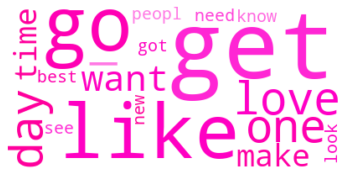

In [48]:
# Female Word Cloud
female_text = iteration(female_wordcounts.map(lambda x: x[1]).take(20))
female_wordcloud = WordCloud(stopwords = stop_words, background_color="white").generate(female_text)

def pink_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(320,150%%, %d%%)" % np.random.randint(40,80))

# Display the generated image:
plt.imshow(female_wordcloud.recolor(color_func = pink_color_func), interpolation='bilinear')
plt.axis("off")
plt.show()

In [49]:
# Top 20 words for male
male_words = male_df.select('stemmed').rdd.flatMap(lambda x: x).flatMap(lambda x: x)
male_wordcounts = male_words.map(lambda x: (x, 1)) \
                  .reduceByKey(lambda x,y:x+y) \
                  .map(lambda x:(x[1],x[0])) \
                  .sortByKey(False)
male_wordcounts.take(20)

[(469, ''),
 (391, 'get'),
 (334, 'like'),
 (290, '-'),
 (270, 'go'),
 (237, 'one'),
 (195, 'love'),
 (188, 'time'),
 (186, 'new'),
 (184, 'make'),
 (175, 'look'),
 (173, 'see'),
 (165, 'know'),
 (161, 'peopl'),
 (155, 'want'),
 (155, 'think'),
 (154, 'good'),
 (148, 'need'),
 (143, 'got'),
 (141, 'day')]

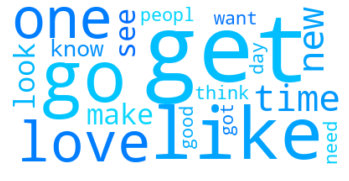

In [50]:
# Male Word Cloud
male_text = iteration(male_wordcounts.map(lambda x: x[1]).take(20))
male_wordcloud = WordCloud(stopwords = stop_words, background_color="white").generate(male_text)

def blue_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(205,250%%, %d%%)" % np.random.randint(30,80))

# Display the generated image:
plt.imshow(male_wordcloud.recolor(color_func = blue_color_func), interpolation='bilinear')
plt.axis("off")
plt.show()

### Pipeline 2
For our second pipeline we:
- create `bigrams` from `stemmed`
- compute term frequency vector for `bigrams`
- combine all relevant columns into `features` using VectorAssembler
- scale `features`

In [51]:
tf = HashingTF(inputCol="stemmed", outputCol="tf") #term frequencies for words

bigrams = NGram(n=2, inputCol="stemmed", outputCol="bigrams") #create bigrams
btf = HashingTF(inputCol="bigrams", outputCol="btf") #term frequencies for bigrams

# create features column
va = VectorAssembler(inputCols=["tf", "btf", "punc", "emojis", "tweet_count_new", "fav_number", 
                                "retweet_count", "account_years"], outputCol="features")

# scale features
scaler1 = StandardScaler(inputCol="features", outputCol="scaledFeatures")
scaler2 = StandardScaler(inputCol="tf", outputCol="scaledTF")

# build pipeline
pipeline = Pipeline(stages=[tf, bigrams, btf, va, scaler1, scaler2])

# fit & tranform pipeline
tweets = pipeline.fit(tweets).transform(tweets)

In [52]:
tweets.columns

['row_index',
 'gender',
 'created',
 'fav_number',
 'retweet_count',
 'text',
 'tweet_count',
 'tweet_created',
 'tweet_count_new',
 'gender_num',
 'words',
 'filtered',
 'punc',
 'emojis',
 'account_years',
 'stemmed',
 'tf',
 'bigrams',
 'btf',
 'features',
 'scaledFeatures',
 'scaledTF']

# Model Construction and Evaluation

### Benchmark Model
Our benchmark model is a multinomial logistic regression model with `scaledTF`, term frequency of tweets, as our only feature.

In [53]:
text = tweets.select("scaledTF", "gender_num") \
        .withColumnRenamed('gender_num', 'label').withColumnRenamed('scaledTF', 'features')
text.cache()

DataFrame[features: vector, label: double]

In [54]:
# Split data
(bench_training, bench_test) = text.randomSplit([0.7,0.3], seed=314)

In [55]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [56]:
lr = LogisticRegression(maxIter=10)
lrModel = lr.fit(bench_training)
predictions = lrModel.transform(bench_test)

evaluator = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = " + str(accuracy))

Accuracy = 0.4881437569470174


### Models with All Features
Now, we will create 4 models using all our features (`tf`, `btf`, `punc`, `emojis`, `tweet_count_new`, `fav_number`, `retweet_count`, `account_years`).

In [57]:
final = tweets.select("scaledFeatures", "gender_num") \
        .withColumnRenamed('gender_num', 'label').withColumnRenamed('scaledFeatures', 'features')
final.cache()

DataFrame[features: vector, label: double]

In [58]:
# Split data
(training, test) = final.randomSplit([0.7,0.3], seed=314)
print("Count of training set = " + str(training.count()))
print("Count of test set = " + str(test.count()))

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 54474)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.7/site-packages/py4j/java_gateway.py", line 1212, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
Traceback (most recent call last):
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/c

Py4JError: An error occurred while calling o1012.count

### Multinomial Logistic Regression

In [40]:
lr = LogisticRegression(maxIter=10)
lrModel = lr.fit(training)
prediction_lr = lrModel.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",
                                              metricName="accuracy")
accuracy_lr = evaluator.evaluate(prediction_lr)
print("Accuracy = " + str(accuracy_lr))

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 52820)
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/py4j/java_gateway.py", line 1207, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/py4j/java_gateway.py", line 1033, in send_command
    response = connection.send_command(command)
  File "/opt/conda/lib/python3.7/site-packages/py4j/java_gateway.py", line 1212, in send_command
    "Error while receiving", e, proto.ERROR_ON_RECEIVE)
py4j.protocol.Py4JNetworkError: Error while receiving
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/socketserver.py", line 316, in _handle_request_noblock
    s

Py4JError: An error occurred while calling o788.fit

### Random Forest

In [49]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rfModel = rf.fit(training)
prediction_rf = rfModel.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",
                                              metricName="accuracy")
accuracy_rf = evaluator.evaluate(prediction_rf)
print("Accuracy = " + str(accuracy_rf))

Accuracy = 0.41793256761763614


### Naive Bayes

In [41]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
nbModel = nb.fit(training)
prediction_nb = nbModel.transform(test)

evaluator = MulticlassClassificationEvaluator(labelCol="label",predictionCol="prediction",
                                              metricName="accuracy")
accuracy_nb = evaluator.evaluate(prediction_nb)
print("Accuracy = " + str(accuracy_nb))

Accuracy = 0.37587995553908854


### KMeans

In [59]:
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator

km = BisectingKMeans().setK(3).setSeed(1)
kmModel = km.fit(training)
predictions_km = kmModel.transform(test)

evaluator = ClusteringEvaluator()
distance = evaluator.evaluate(predictions_km)
print("Silhouette Squared Euclidean Distance = " + str(distance))

Squared Euclidean Distance = 0.0039646477228593435


In [ ]:
print("Multinomial Logistic Regression Accuracy = " + str(accuracy_lr))
print("Random Forest Accuracy = " + str(accuracy_rf))
print("Naive Bayes Accuracy = " + str(accuracy_nb))
print("KMeans Squared Euclidean Distance = " + str(distance))